# Classification of student success using Random Forest and Neural Networks

The present work used the Open University dataset described in the following article.
> Kuzilek, J., Hlosta, M., & Zdrahal, Z. (2017). Data Descriptor: Open University Learning Analytics dataset. Scientific Data, 4, 1–8. https://doi.org/10.1038/sdata.2017.171


Google Drive was used to store the data set



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path2data='/content/drive/My Drive/Python Datasets/Students Success/dataset/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Transformation

The fields of interest were extracted in two files databaseFinal0.csv and databaseFinal1.csv, corresponding to the year 2013 and 2014 and the code module FFF.

In [ ]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

assessments = pd.read_csv(path2data+'assessments.csv')
courses = pd.read_csv(path2data+'courses.csv')
studentAssessment = pd.read_csv(path2data+'studentAssessment.csv')
studentInfo = pd.read_csv(path2data+'studentInfo.csv')
studentRegistration = pd.read_csv(path2data+'studentRegistration.csv')
studentVle = pd.read_csv(path2data+'studentVle.csv')
vle = pd.read_csv(path2data+'vle.csv')

studentVle=studentVle.drop(columns=['date'])
code_pre=["2013J","2014J"]
for count,ele in enumerate(code_pre):
  df = pd.merge(studentAssessment,assessments,on = 'id_assessment')
  df = df[df['code_module'] == "FFF"]
  df = df[df['code_presentation'] == ele]

  df2 = pd.merge(df, studentInfo,  how='left', left_on=['id_student','code_presentation','code_module'], right_on = ['id_student','code_presentation','code_module'])
  data_top = studentVle.head() 
  dfvle = pd.merge(vle, studentVle, how='left', left_on=['id_site', 'code_presentation','code_module'], right_on = ['id_site', 'code_presentation', 'code_module'])

  dfT = pd.merge(df2, dfvle, how='left', left_on=['id_student', 'code_presentation','code_module'], right_on = ['id_student', 'code_presentation', 'code_module'])
  #dfT = dfT[['id_student','code_presentation','code_module',"gender","age_band","num_of_prev_attempts","disability","id_assessment","date","weight","score","final_result","sum_click"]]

  #Feature Selection
  feature_list=['id_student','code_presentation','code_module',"gender","age_band","num_of_prev_attempts","disability","id_assessment","date","weight","score","final_result","sum_click","region","highest_education"]
  #Without Feature Selection
  #feature_list=['id_student','code_presentation','code_module',"gender","age_band","num_of_prev_attempts","disability","id_assessment","date","weight","score","final_result","sum_click"]
  dfT = dfT[feature_list]

  feature_list.remove("sum_click")
  gkk = dfT.groupby(feature_list).agg(totalClick=('sum_click', 'sum'), interacions=('sum_click', 'count'), stdDev=('sum_click', 'std'), max=('sum_click', 'max'), min=('sum_click', 'min'))
  gkk = gkk.fillna(0)

  gkk.to_csv('databaseFinal'+str(count)+'.csv')

In [ ]:

tagFiles=["train","test"]
for count,ele in enumerate(tagFiles):
  dataX=[]
  label = []
  pd.set_option('display.max_columns', None)
  database = pd.read_csv('./databaseFinal'+str(count)+'.csv')
  #database = pd.concat([database,pd.get_dummies(database['age_band'], prefix='age')],axis=1)
  #database = pd.concat([database,pd.get_dummies(database['gender'], prefix='gender')],axis=1)
  #database = pd.concat([database,pd.get_dummies(database['disability'], prefix='disability')],axis=1)
  #database = pd.concat([database,pd.get_dummies(database['final_result'], prefix='final_result')],axis=1)

  #database.drop(['age_band'],axis=1, inplace=True)
  #database.drop(['gender'],axis=1, inplace=True)
  #database.drop(['disability'],axis=1, inplace=True)
  #database.drop(['final_result'],axis=1, inplace=True)

  database.totalClick = database.totalClick.replace({0: (1-np.finfo(float).eps)})
  database.interacions = database.interacions.replace({0: (1-np.finfo(float).eps)})
  database.totalClick = np.log(database.totalClick)
  database.interacions = np.log(database.interacions)

  idStudents=database.id_student.unique()
  X = np.array([], dtype=np.int64).reshape(0,111)
  Y = np.array([], dtype=np.int64).reshape(0,4)
  rowNameX=[]
  for i in idStudents:
      rowNameX.append(i)
      #samplei=np.zeros((1, 111))
      samplei=[]
      
      df = database[database['id_student'] == i]
      df = df.sort_values(by=['date'])
      weightzero = df.weight.unique()
      vecCalificacion = np.zeros((1, 1000))
      avgZeroWeight=0
      if 0 in weightzero:
          dfTemp = df[df['weight'] == 0]
          avgZeroWeight=dfTemp["score"].mean()
      samplei.append(avgZeroWeight)
      df = df[df.weight != 0]
      itColVCali=0;
      for index, row in df.iterrows():
          val=int(row['weight']*10)
          for j in range(val):
              vecCalificacion[0,itColVCali]=row['score']/10
              itColVCali=itColVCali+1
      for j in range(100):
          samplei.append(vecCalificacion[0,j*10])
      samplei.append(row['totalClick'])
      samplei.append(row['interacions'])
      samplei.append(row['stdDev'])
      samplei.append(row['max'])
      samplei.append(row['min'])
      samplei.append(row['age_band'])
      samplei.append(row['num_of_prev_attempts'])
      samplei.append(row['gender'])
      samplei.append(row['disability'])
      samplei.append(row['region'])
      samplei.append(row['highest_education'])
      samplei.append(row['final_result'])
      label.append(row['final_result'])

      dataX.append(samplei)

  columnName=['Col'+str(i) for i in range(101)]
  listaLabels=['totalClick','interacions','stdDev',"max","min",'age_band','num_of_prev_attempts','gender','disability','region','highest_education',"final_result"]
  columnName1=columnName+listaLabels
  dfFinal1 = pd.DataFrame(data=dataX, columns=columnName1)
  columnName2=['final_result']
  dfFinal2 = pd.DataFrame(data=label, columns=columnName2)
  
  Multiclass_features=False
  if Multiclass_features:
    #Multi-class dataset
    dfFinal1.to_csv('X'+ele+'.csv')
    dfFinal2.to_csv('Y'+ele+'.csv')
  else:  #Change 4 classes to 2 classes
    dfFinal1.loc[dfFinal1['final_result'] == "Withdrawn", 'final_result'] = "Fail"
    dfFinal1.loc[dfFinal1['final_result'] == "Distinction", 'final_result'] = "Pass"
    dfFinal2.loc[dfFinal2['final_result'] == "Withdrawn", 'final_result'] = "Fail"
    dfFinal2.loc[dfFinal2['final_result'] == "Distinction", 'final_result'] = "Pass"
    #Binary-class dataset
    dfFinal1.to_csv('X'+ele+'.csv')
    dfFinal2.to_csv('Y'+ele+'.csv')


In [ ]:
!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator

In [ ]:
import h2o
h2o.init()
#4 classes
df = h2o.import_file("Xtrain.csv")
df2 = h2o.import_file("Xtest.csv")



Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 hour 0 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.6
H2O_cluster_version_age:,10 days
H2O_cluster_name:,H2O_from_python_unknownUser_53pqcw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.112 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


Random Forest for the Multi-class Classification

In [ ]:
training_columns =columnName1.copy()
training_columns.remove("final_result")
response_column = "final_result"

model = H2ORandomForestEstimator(ntrees=50, max_depth=100, nfolds=10)

model.train(x=training_columns, y=response_column, training_frame=df)
performance = model.model_performance(test_data=df2)

print(performance)

drf Model Build progress: |███████████████████████████████████████████████| 100%

ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.0622868255372227
RMSE: 0.24957328690631675
LogLoss: 0.3666688131338029
Mean Per-Class Error: 0.09167154836847957
AUC: 0.967946106011986
AUCPR: 0.9717696660248805
Gini: 0.9358922120239721

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49: 


,,Fail,Pass,Error,Rate
0,Fail,621.0,98.0,0.1363,(98.0/719.0)
1,Pass,61.0,1062.0,0.0543,(61.0/1123.0)
2,Total,682.0,1160.0,0.0863,(159.0/1842.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.490000,0.930355,127.0
1,max f2,0.160000,0.965624,169.0
2,max f0point5,0.750000,0.934770,83.0
3,max accuracy,0.497143,0.913681,125.0
4,max precision,1.000000,0.984152,0.0
5,max recall,0.020000,1.000000,183.0
6,max specificity,1.000000,0.986092,0.0
7,max absolute_mcc,0.497143,0.817699,125.0
8,max min_per_class_accuracy,0.640000,0.906815,104.0
9,max mean_per_class_accuracy,0.610000,0.908328,108.0



Gains/Lift Table: Avg response rate: 60.97 %, avg score: 60.78 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.342562,1.00,1.614255,1.614255,0.984152,1.000000,0.984152,1.000000,0.552983,0.552983,61.425489,61.425489,0.539075
1,2,0.409881,0.96,1.547655,1.603317,0.943548,0.974566,0.977483,0.995823,0.104185,0.657168,54.765461,60.331657,0.633524
2,3,0.501629,0.86,1.533488,1.590545,0.934911,0.906849,0.969697,0.979549,0.140695,0.797863,53.348754,59.054481,0.758920
3,4,0.602606,0.60,1.199322,1.524989,0.731183,0.731105,0.929730,0.937918,0.121104,0.918967,19.932209,52.498857,0.810483
4,5,0.700326,0.18,0.747225,1.416463,0.455556,0.405262,0.863566,0.863594,0.073019,0.991986,-25.277530,41.646338,0.747201
5,6,1.000000,0.00,0.026743,1.000000,0.016304,0.010184,0.609663,0.607849,0.008014,1.000000,-97.325680,0.000000,0.000000


In [ ]:
#model_path = h2o.save_model(model=model, path="./mymodel", force=True)

## Feature Selection

In [ ]:
featureImportance=model.varimp(True) # variable, relative importance, scaled importance, percentage
#pd.set_option("display.max_rows", None, "display.max_columns", None)

featureImportance.to_csv('featureImportanceBin2.csv')



In [ ]:
dfFeat=featureImportance[featureImportance['scaled_importance']>.05]
dfFeatListCat=list(dfFeat["variable"])
dfFeatList=columnName.copy()
for i in dfFeatListCat:
  if i not in dfFeatList:
    dfFeatList.append(i)
print(dfFeatList)
print(len(dfFeatList))

['Col0', 'Col1', 'Col2', 'Col3', 'Col4', 'Col5', 'Col6', 'Col7', 'Col8', 'Col9', 'Col10', 'Col11', 'Col12', 'Col13', 'Col14', 'Col15', 'Col16', 'Col17', 'Col18', 'Col19', 'Col20', 'Col21', 'Col22', 'Col23', 'Col24', 'Col25', 'Col26', 'Col27', 'Col28', 'Col29', 'Col30', 'Col31', 'Col32', 'Col33', 'Col34', 'Col35', 'Col36', 'Col37', 'Col38', 'Col39', 'Col40', 'Col41', 'Col42', 'Col43', 'Col44', 'Col45', 'Col46', 'Col47', 'Col48', 'Col49', 'Col50', 'Col51', 'Col52', 'Col53', 'Col54', 'Col55', 'Col56', 'Col57', 'Col58', 'Col59', 'Col60', 'Col61', 'Col62', 'Col63', 'Col64', 'Col65', 'Col66', 'Col67', 'Col68', 'Col69', 'Col70', 'Col71', 'Col72', 'Col73', 'Col74', 'Col75', 'Col76', 'Col77', 'Col78', 'Col79', 'Col80', 'Col81', 'Col82', 'Col83', 'Col84', 'Col85', 'Col86', 'Col87', 'Col88', 'Col89', 'Col90', 'Col91', 'Col92', 'Col93', 'Col94', 'Col95', 'Col96', 'Col97', 'Col98', 'Col99', 'Col100', 'region', 'totalClick', 'stdDev']
104


In [ ]:
dataTrainFilter=df[dfFeatList].as_data_frame(use_pandas=True, header=True)
dataTestFilter=df2[dfFeatList].as_data_frame(use_pandas=True, header=True)

listOfCategorical=dataTrainFilter.select_dtypes(exclude=['int', 'float']).columns.tolist()

In [ ]:
labelTrainFilter=df["final_result"].as_data_frame(use_pandas=True, header=True)
labelTestFilter=df2["final_result"].as_data_frame(use_pandas=True, header=True)

In [ ]:
for l in listOfCategorical:
  dataTrainFilter = pd.concat([dataTrainFilter,pd.get_dummies(dataTrainFilter[l], prefix=l)],axis=1)
  dataTrainFilter.drop([l],axis=1, inplace=True)
  dataTestFilter = pd.concat([dataTestFilter,pd.get_dummies(dataTestFilter[l], prefix=l)],axis=1)
  dataTestFilter.drop([l],axis=1, inplace=True)
labelTrainFilter = pd.concat([labelTrainFilter,pd.get_dummies(labelTrainFilter["final_result"], prefix="final_result")],axis=1)
labelTrainFilter.drop(["final_result"],axis=1, inplace=True)
labelTestFilter = pd.concat([labelTestFilter,pd.get_dummies(labelTestFilter["final_result"], prefix="final_result")],axis=1)
labelTestFilter.drop(["final_result"],axis=1, inplace=True)

In [ ]:
#For save the Model
#saved_model = h2o.load_model("./mymodel/DRF_model_python_1594070609089_1")
#performance = saved_model.model_performance(test_data=df2)
#print(performance)

## Classification

The model input is encoded in a 113-element feature vector that includes the following information:



*   Assignment performance
*   Interaction with the VLE
*   Student data


The architecture of the full-dense Multilayer Perceptron model is given by 106/104 input neurons, 250,250/200 hidden layer neurons, and 4/1 output layer neurons

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

#XTrain = pd.read_csv('Xtrain.csv')
#XTest = pd.read_csv('Xtest.csv')
#YTrain = pd.read_csv('Ytrain.csv')
#YTest = pd.read_csv('Ytest.csv')
XTrain = dataTrainFilter
XTest = dataTestFilter
YTrainS = labelTrainFilter
YTestS = labelTestFilter

#Normalize the data
scaler = MinMaxScaler()
XTrainS=scaler.fit_transform(XTrain.values)
XTestS=scaler.fit_transform(XTest.values)
#YTrainS=scaler.fit_transform(YTrain.values)
#YTestS=scaler.fit_transform(YTest.values)
#
#Not Normalize
"""XTrainS=XTrain.values
XTestS=XTest.values
YTrainS=YTrain.values
YTestS=YTest.values"""

from tensorflow.keras.layers import Dropout
model = Sequential()
#Multiclass
#model.add(Dense(250, input_shape=(dataTrainFilter.shape[1],), activation='relu'))
#model.add(Dense(250, activation='relu'))
#model.add(Dense(4, activation='softmax'))
#model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
#Binaryclass
model.add(Dense(200, input_shape=(dataTrainFilter.shape[1],), activation='relu'))
#model.add(Dense(200, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
#
model.summary()
#Multiclass
#history=model.fit(XTrainS, YTrainS, validation_split=0.33, epochs=500)
#Binaryclass
history=model.fit(XTrainS, YTrainS.values[:,0], epochs=100)



Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_80 (Dense)             (None, 200)               23400     
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 201       
Total params: 23,601
Trainable params: 23,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
59/59 [==============================] - 0s 2ms/step - loss: 0.3038 - accuracy: 0.8825
Epoch 2/100
59/59 [==============================] - 0s 3ms/step - loss: 0.2251 - accuracy: 0.9076
Epoch 3/100
59/59 [==============================] - 0s 3ms/step - loss: 0.2184 - accuracy: 0.9087
Epoch 4/100
59/59 [==============================] - 0s 3ms/step - loss: 0.2121 - accuracy: 0.9087
Epoch 5/100
59/59 [==============================] - 0s 2ms/step - loss: 0.2078 - accuracy: 0.9097
Epoch 6/100
59/5

In [ ]:
y_pred = model.predict(XTestS)
#Multi-class
#y_test_class = np.argmax(YTestS, axis=1)#
#y_pred_class = np.argmax(y_pred, axis=1)#
#Binary-class
y_test_class = YTestS.values[:,0]#
y_pred_class = np.round(y_pred[:,0])#
print(y_test_class)
print(y_pred_class)
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_class, y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))

[1 1 1 ... 0 1 0]
[1. 1. 1. ... 0. 1. 0.]
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      1123
           1       0.92      0.86      0.89       719

    accuracy                           0.92      1842
   macro avg       0.92      0.91      0.91      1842
weighted avg       0.92      0.92      0.92      1842

[[1066   57]
 [  98  621]]


In [ ]:
model.save("modelBinary.h5")

The confusion matrix was plotted using Dennis Trimarchi's code

> https://github.com/DTrimarchi10/confusion_matrix



In [ ]:
!git clone https://github.com/DTrimarchi10/confusion_matrix.git

Cloning into 'confusion_matrix'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 15 (delta 3), reused 15 (delta 3), pack-reused 0
Unpacking objects: 100% (15/15), done.


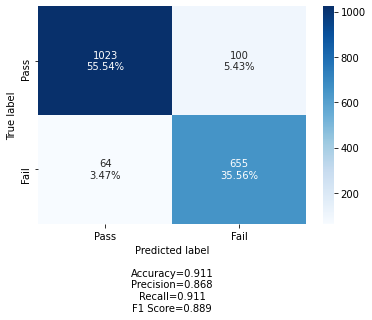

In [ ]:
import confusion_matrix.cf_matrix as cm
import matplotlib.pyplot as plt


categories = ["Pass", "Fail"]
X=cm.make_confusion_matrix(confusion_matrix(y_test_class,y_pred_class),
                      categories=categories, 
                      cmap="Blues")